# Unsupervised Learning meets emergent patters
#### How unsupervised learning can help us detecting phase transitions and emergent phenomena

## Imports

In [35]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time

In [5]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 2D Ising model simulation by MCMC

### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [6]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    elif string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

In [7]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

In [8]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

In [9]:
# Order Parameter
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

In [10]:
# Matrix containing all the system states
@jit(nopython=True,fastmath=True,nogil=True)
def Matrix_X(Temps,config,iterations,J,n):

    X = np.zeros((len(Temps),n*n))

    for t in range(len(Temps)):

        beta = 1/Temps[t]

        #thermal equilibrium
        for i in range(iterations):
            config = MC_met(config,beta, J)
            
        X[t,:] = np.reshape(config,(n*n))
    

    return  X



## Experimental setup

In [45]:
J = 1     # J
n = 100    # Lattice size
iterations = (n*n)*n    # Iterations to thermal equilibrium
T_1 = np.linspace(1.6,2.21,100)
T_2 = np.linspace(2.21,2.4,100)
T_3 = np.linspace(2.5,4,100)
Temps = np.hstack((T_1,T_2,T_3 )).ravel()



In [46]:
config = initial_state(n,"aligned")


X = Matrix_X(Temps, config,iterations,J,n)

In [47]:
X.shape

(300, 10000)

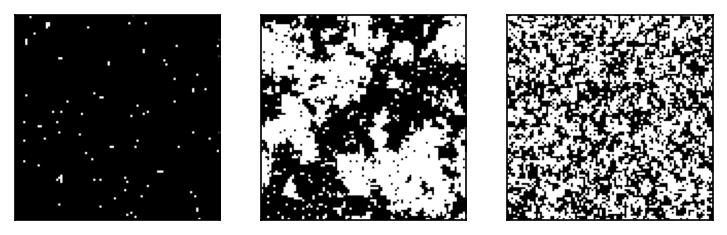

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=150)

ax1.imshow(X[0,:].reshape(n,n), cmap='Greys')
ax2.imshow(X[150,:].reshape(n,n), cmap='Greys')
ax3.imshow(X[-1,:].reshape(n,n), cmap='Greys')

for i in [ax1,ax2,ax3]:
    i.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.show()

## PCA

In [24]:

# PCA
pca = PCA()

XPCA = pca.fit_transform(X)

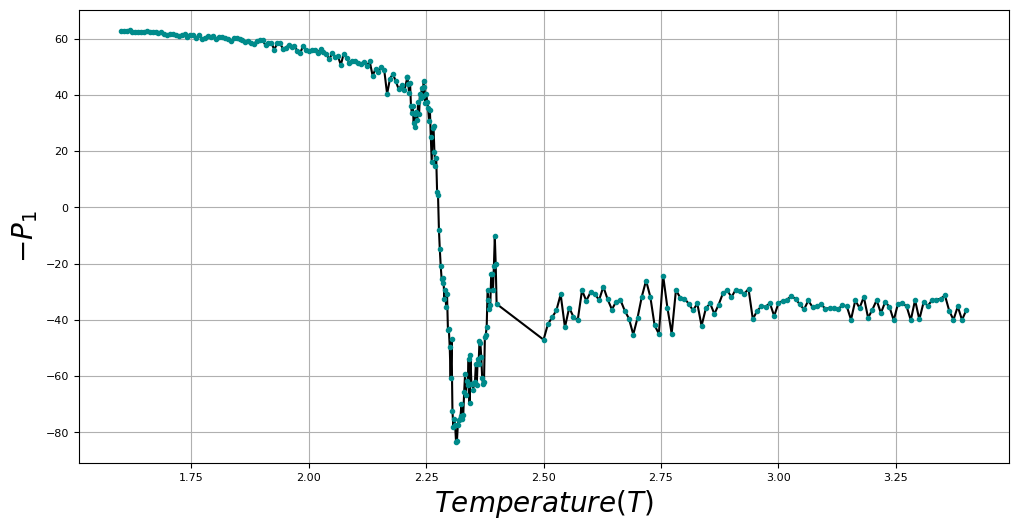

In [25]:

# Plot first and second principal component.

plt.figure(figsize=(12,6),dpi=100)

plt.plot(Temps,-XPCA[:,0], color='black')#,c=Temps, cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)
plt.plot(Temps,-XPCA[:,0],'.', color='darkcyan')
#plt.colorbar()
plt.ylabel(r'$-P_1$')
plt.xlabel(r'$Temperature (T)$')
plt.grid()

plt.show()

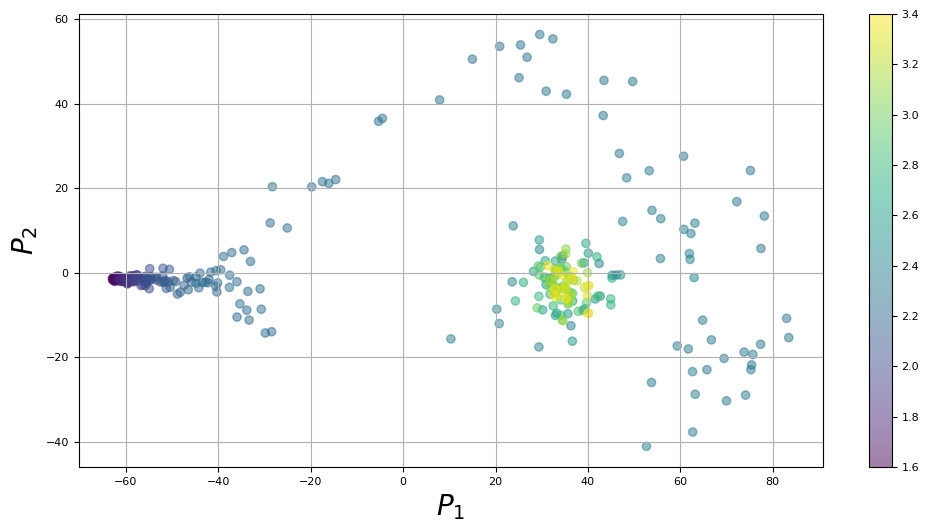

In [26]:

# Plot first and second principal component.

plt.figure(figsize=(12,6),dpi=100)

plt.scatter(XPCA[:,0], XPCA[:,1],c=Temps, cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)

plt.colorbar()
plt.ylabel(r'$P_2$')
plt.xlabel(r'$P_1$')
plt.grid()

plt.show()

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_30470/2726475340.py:11: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.



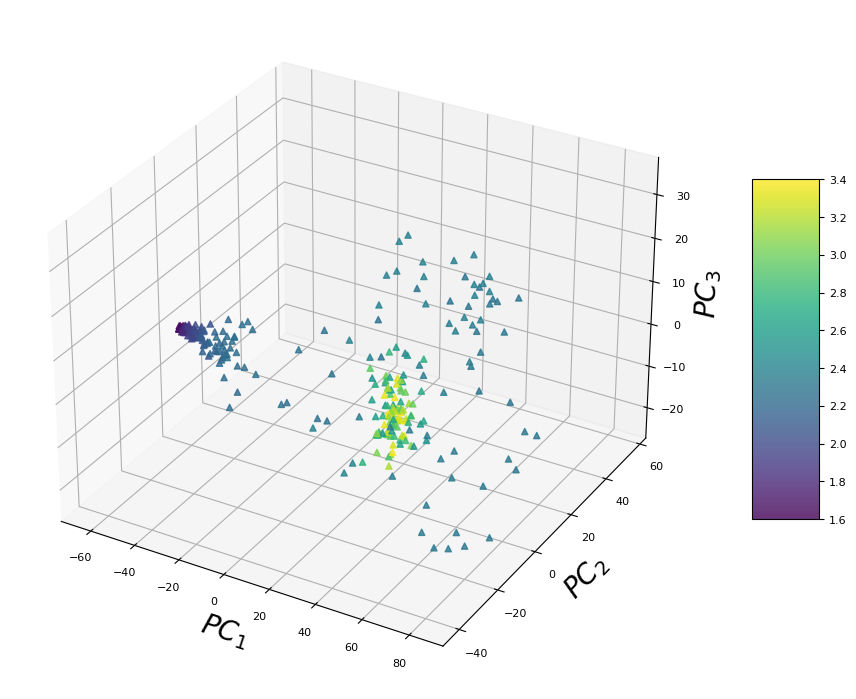

In [28]:
from mpl_toolkits import mplot3d
x = XPCA[:,0]
y = XPCA[:,1]
z = XPCA[:,2]

# Creating figure
fig = plt.figure(figsize = (16, 9), dpi=100)
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = Temps,
                    cmap = 'viridis',
                    marker ='^')

ax.set_xlabel(r'$PC_1$', fontweight ='bold')
ax.set_ylabel(r'$PC_2$', fontweight ='bold')
ax.set_zlabel(r'$PC_3$', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()


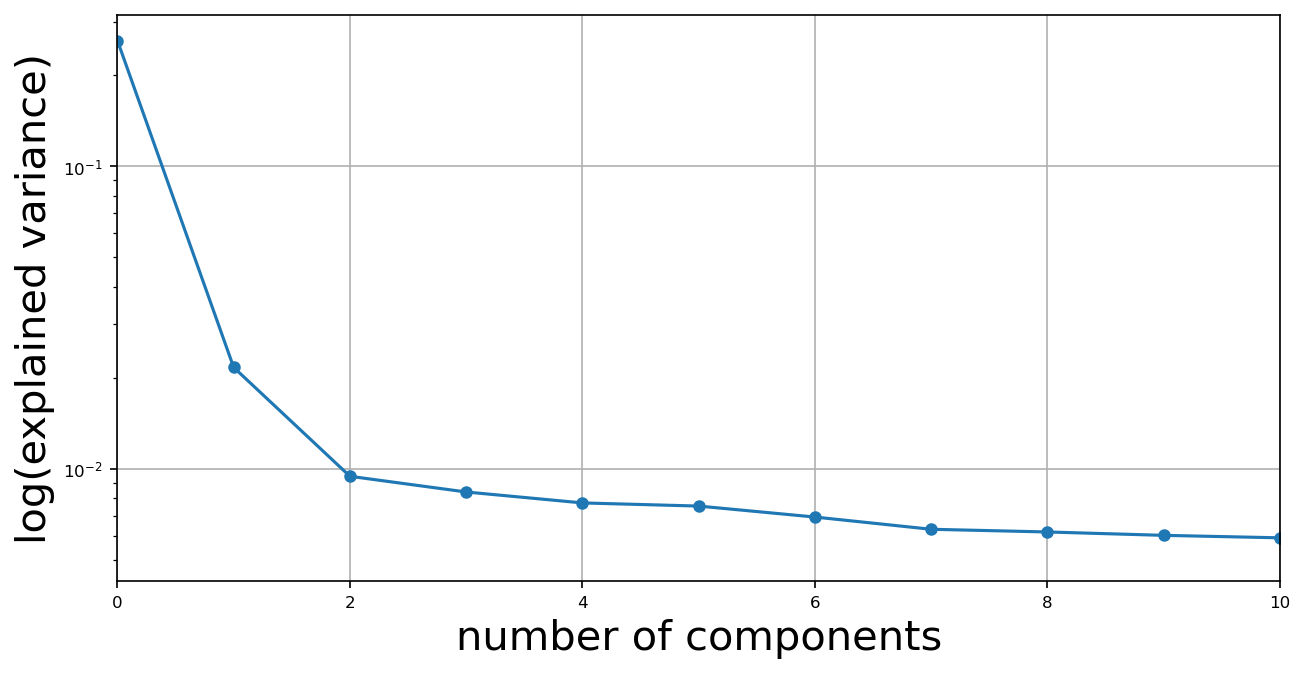

In [29]:
plt.figure(figsize=(10,5), dpi=150)
plt.plot(pca.explained_variance_ratio_[:-280], marker='.', markersize=10)
plt.xlabel(r'number of components')
plt.ylabel('log(explained variance)');
plt.yscale('log')
plt.xlim(0,10)
plt.grid()
plt.show()

## Components coeficients

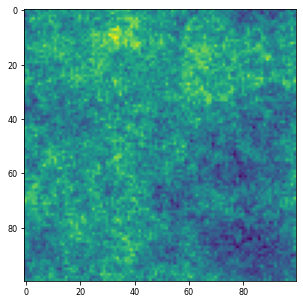

In [65]:
plt.figure(figsize=(5,5))
plt.imshow(pca.components_[0].reshape((n,n)))

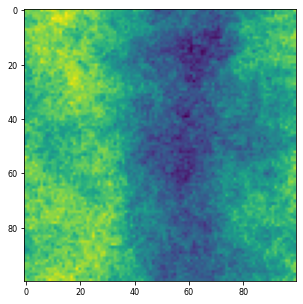

In [66]:
plt.figure(figsize=(5,5))
plt.imshow(pca.components_[1].reshape((n,n)))